<a href="https://colab.research.google.com/github/indahnr/Deep_Learning/blob/main/week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concise Implementation of Recurrent Neural Networks

In [20]:
!pip install d2l==0.17.5


In [21]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [22]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

In [23]:
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

In [24]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

In [25]:
#save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # Later RNN like `tf.keras.layers.LSTMCell` return more than two values
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

In [26]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller', 10, net, vocab)

'time travellerauusmhsedz'

perplexity 1.4, 19793.2 tokens/sec on /GPU:0
time travellerit would be remarkably convenient for the historia
travellerthat or chattirk of thes thine dree ats tfer of th


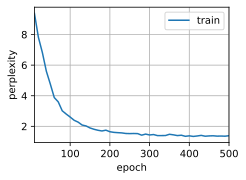

In [27]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)